In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
import itertools


%matplotlib inline

# Functions

Display images before any pre-processing

In [ ]:
def show_img(num, img_array, title, ncols=1):

    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

 Show images from a dataframe with index  (with cropped & resized function)

In [ ]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):

    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)

Show images from an array dataset (with cropped & resized function)

In [ ]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):

    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

Summary

In [ ]:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")

NameError: name 'od' is not defined

In [3]:

label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}
train_dir = '/content/drive/My Drive/archive/FaceShape Dataset/training_set'
test_dir = '/content/drive/My Drive/archive/FaceShape Dataset/testing_set'
example_dir = '/content/drive/My Drive/archive/FaceShape Dataset/examples'
categories = ['Heart','Oblong','Oval','Round','Square']

Reads the images and create training & testing datasets

In [ ]:
def create_data_files(directory, array, resize=(224,224)):

    i=0
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        img_list = os.listdir(path)
        try:
            for img in img_list:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                if resize != None:
                  img_array = cv2.resize(img_array, resize)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')


        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [ ]:
training_data = []
testing_data = []

create_data_files(train_dir, training_data)
create_data_files(test_dir, testing_data)



Images processed: 800 of 4000
Error: 
 category: Oblong
 image: oblong (724).jpg
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Error: 
 category: Round
 image: desktop.ini


In [ ]:
training_data = np.array(training_data, dtype=object) # Use dtype=object to handle mixed data types
testing_data = np.array(testing_data, dtype=object)

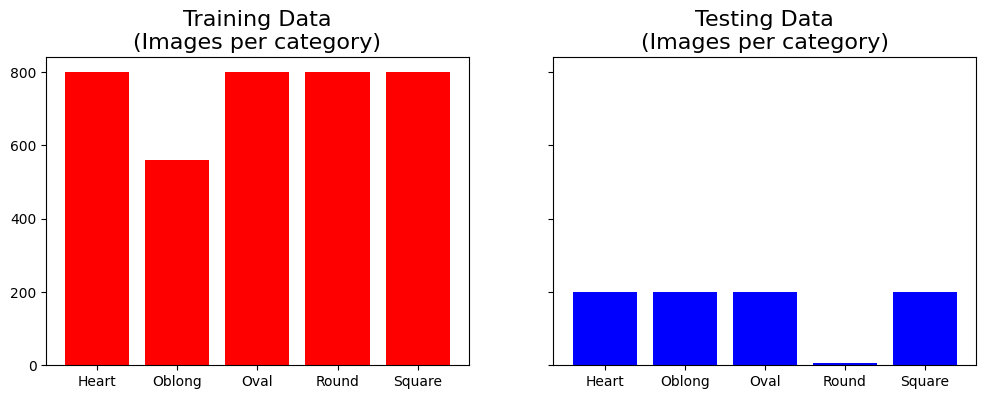

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='red')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='blue')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

In [ ]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (3761, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [800 561 800 800 800]
Max Pixels: 255

--------------------------------------


Testing Dataset:

Shape: (806, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [200 200 200   6 200]
Max Pixels: 245

--------------------------------------



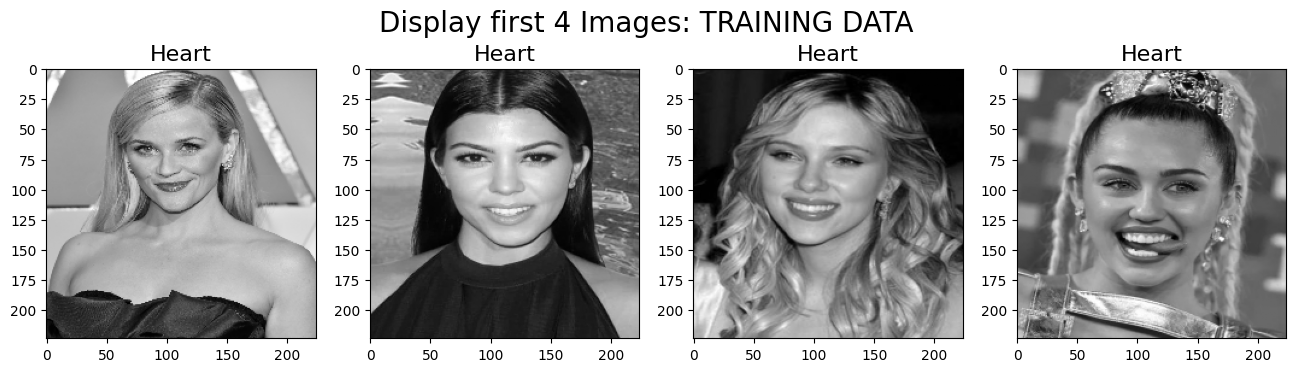

In [ ]:
show_img(4, training_data[:4], 'Display first 4 Images: TRAINING DATA', ncols=4)

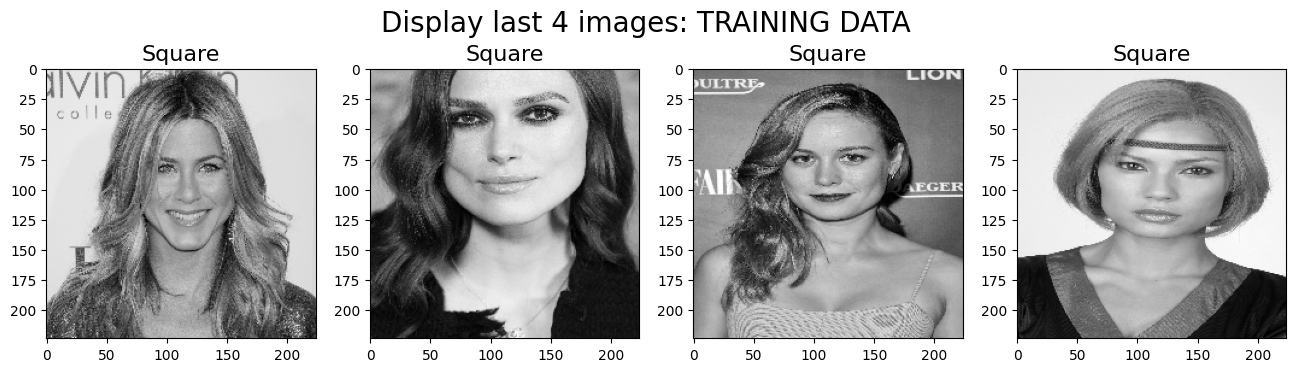

In [ ]:
show_img(4, training_data[len(training_data)-4:], 'Display last 4 images: TRAINING DATA', ncols=4)

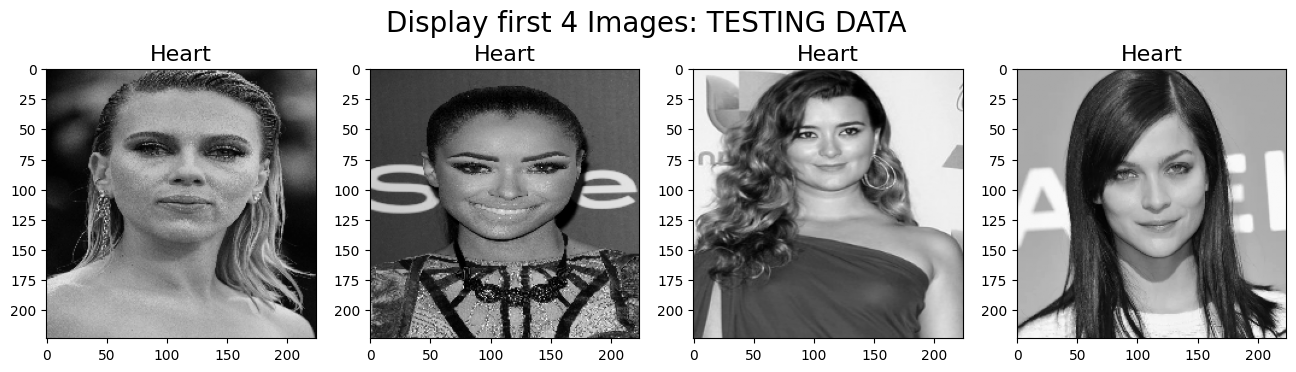

In [ ]:
show_img(4, testing_data[:4], 'Display first 4 Images: TESTING DATA', ncols=4)

# Data Pre-processing

In [ ]:
shape = []

for image, label in training_data:
    try:
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        print("shape not found")

shape[:5]

[(224, 224), (224, 224), (224, 224), (224, 224), (224, 224)]

In [ ]:
train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map)
train.head(2)

,img_array,class,img_shape,face_shape
0,"[[194, 194, 194, 192, 162, 129, 142, 176, 195,...",0,"(224, 224)",Heart
1,"[[82, 76, 67, 63, 63, 63, 60, 60, 64, 63, 63, ...",0,"(224, 224)",Heart


In [ ]:
train.sort_values(by='img_shape', ascending=False)

,img_array,class,img_shape,face_shape
0,"[[194, 194, 194, 192, 162, 129, 142, 176, 195,...",0,"(224, 224)",Heart
2512,"[[110, 104, 96, 82, 81, 78, 76, 72, 76, 73, 68...",3,"(224, 224)",Round
2500,"[[205, 205, 205, 205, 205, 205, 205, 205, 205,...",3,"(224, 224)",Round
2501,"[[247, 242, 242, 241, 246, 244, 224, 190, 186,...",3,"(224, 224)",Round
2502,"[[219, 219, 219, 220, 220, 218, 219, 219, 220,...",3,"(224, 224)",Round
...,...,...,...,...
1258,"[[106, 107, 108, 109, 108, 107, 106, 105, 104,...",1,"(224, 224)",Oblong
1259,"[[184, 186, 187, 189, 190, 192, 192, 193, 194,...",1,"(224, 224)",Oblong
1260,"[[212, 214, 217, 215, 214, 215, 213, 212, 211,...",1,"(224, 224)",Oblong
1261,"[[219, 219, 219, 139, 59, 59, 59, 58, 58, 59, ...",1,"(224, 224)",Oblong


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   3761 non-null   object
 1   class       3761 non-null   object
 2   img_shape   3761 non-null   object
 3   face_shape  3761 non-null   object
dtypes: object(4)
memory usage: 117.7+ KB


In [ ]:
train['height'] = train['img_shape'].map(lambda x : x[0])
train['width'] = train['img_shape'].map(lambda x : x[1])
train['aspect_ratio'] = train['width'] / train['height']
train

,img_array,class,img_shape,face_shape,height,width,aspect_ratio
0,"[[194, 194, 194, 192, 162, 129, 142, 176, 195,...",0,"(224, 224)",Heart,224,224,1.0
1,"[[82, 76, 67, 63, 63, 63, 60, 60, 64, 63, 63, ...",0,"(224, 224)",Heart,224,224,1.0
2,"[[27, 21, 17, 17, 18, 17, 17, 17, 19, 21, 21, ...",0,"(224, 224)",Heart,224,224,1.0
3,"[[152, 160, 164, 168, 170, 171, 169, 169, 170,...",0,"(224, 224)",Heart,224,224,1.0
4,"[[107, 115, 125, 136, 142, 144, 142, 142, 145,...",0,"(224, 224)",Heart,224,224,1.0
...,...,...,...,...,...,...,...
3756,"[[110, 111, 109, 110, 111, 111, 109, 110, 111,...",4,"(224, 224)",Square,224,224,1.0
3757,"[[182, 185, 182, 183, 182, 182, 183, 182, 184,...",4,"(224, 224)",Square,224,224,1.0
3758,"[[202, 202, 202, 202, 202, 202, 202, 202, 202,...",4,"(224, 224)",Square,224,224,1.0
3759,"[[190, 189, 189, 190, 191, 193, 192, 193, 193,...",4,"(224, 224)",Square,224,224,1.0


In [ ]:
train.describe()

,height,width,aspect_ratio
count,3761.0,3761.0,3761.0
mean,224.0,224.0,1.0
std,0.0,0.0,0.0
min,224.0,224.0,1.0
25%,224.0,224.0,1.0
50%,224.0,224.0,1.0
75%,224.0,224.0,1.0
max,224.0,224.0,1.0


Histogram

In [ ]:
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels,
                       figsize=(10,8), bins = 15,ncols=2,nrows=0, sharex=True, sharey=True, figtitle=None):

    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols,
                           sharex=sharex, sharey=sharey) # You'll want to specify your figsize
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=bins, color='mediumaquamarine') # feel free to add more settings
        ax[i].set_title(list_of_titles[i])# Set titles, labels, etc here for each subplot
        if (i >= (ncols*nrows)/2):
            ax[i].set_xlabel(list_of_xlabels[i])  # only show x labels on bottom ax plots
        if (sharey==True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # only show y labels on left ax plots
    plt.tight_layout()

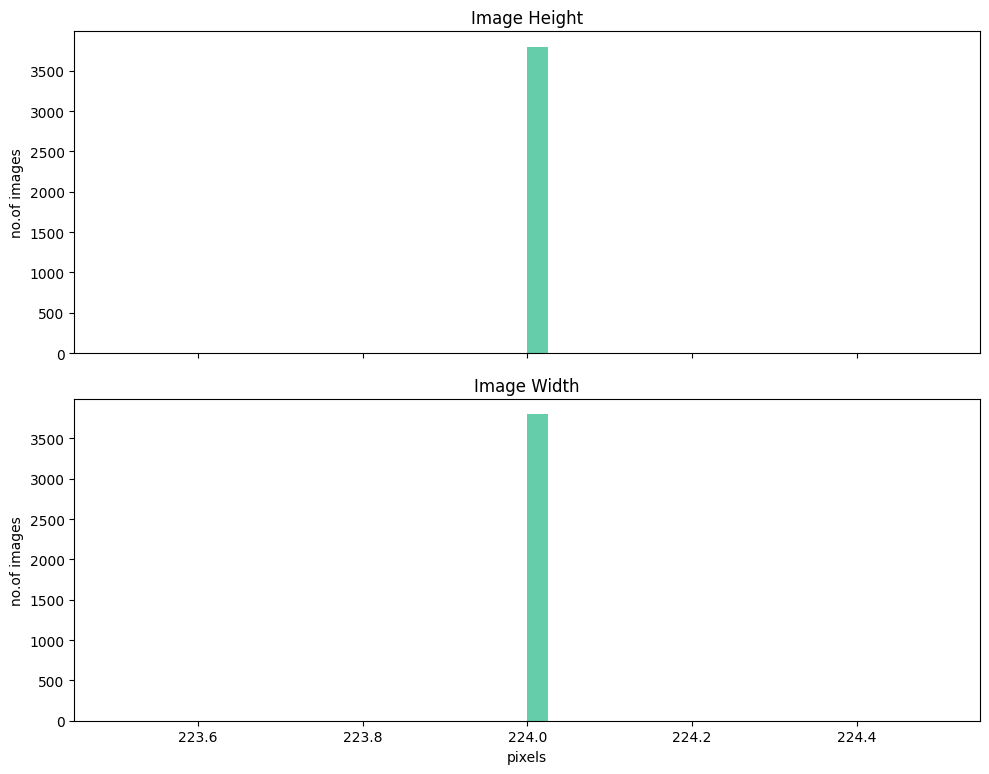

In [ ]:

subplot_histograms(train, ['height', 'width'],
                   ['Image Height', 'Image Width'],
                   ['pixels','pixels'],
                   ['no.of images','no.of images'],
                   figsize=(10,8), bins = 40,ncols=1,nrows=2,
                   sharex=True, sharey=True, figtitle=None)

In [ ]:
def train_test_prep(training_data_array, testing_data_array):

    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [ ]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [ ]:
training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

Images processed: 800 of 4000
Error: 
 category: Oblong
 image: oblong (724).jpg
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Error: 
 category: Round
 image: desktop.ini


In [ ]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3761, 224, 224)
X_test.shape (806, 224, 224)
y_train.shape (3761, 5)
y_test.shape (806, 5)


In [ ]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3761, 224, 224, 1)
X_test.shape (806, 224, 224, 1)
y_train.shape (3761, 5)
y_test.shape (806, 5)


Resize

In [ ]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [ ]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

# Detector

In [ ]:
!pip install lz4

In [ ]:
import cv2
from mtcnn.mtcnn import MTCNN

# Load the image (Make sure the path is correct)
image_path = '/content/drive/MyDrive/archive/FaceShape Dataset/testing_set/Heart/heart (101).jpg'
img = cv2.imread(image_path)

# Check if image is loaded correctly
if img is None:
    print("Error: Could not load image. Check the file path.")
else:
    # Convert image from BGR (OpenCV format) to RGB (MTCNN format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create an MTCNN detector
    detector = MTCNN()

    # Detect faces in the image
    results = detector.detect_faces(img_rgb)

    # Show the results
    print("Detected faces:", results)

    # Draw bounding boxes on detected faces
    for result in results:
        x, y, width, height = result['box']
        cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Save and show the output image
    output_path = 'detected_faces.jpg'
    cv2.imwrite(output_path, img)
    print(f"Processed image saved as {output_path}")


ValueError: LZ4 is not installed. Install it with pip: https://python-lz4.readthedocs.io/

In [ ]:
# Install required libraries (only needed once per session)
!pip install mtcnn lz4

# Import necessary libraries
import cv2
from mtcnn.mtcnn import MTCNN

# Load the image (Ensure the correct path is provided)
image_path = '/content/drive/MyDrive/archive/FaceShape Dataset/testing_set/Heart/heart (101).jpg'  # Change this to the actual image path
img = cv2.imread(image_path)

# Check if the image was loaded correctly
if img is None:
    print("Error: Image not found or incorrect path provided.")
else:
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create an MTCNN detector
    detector = MTCNN()

    # Detect faces in the image
    results = detector.detect_faces(img_rgb)

    # Show the results
    print(results)


ValueError: LZ4 is not installed. Install it with pip: https://python-lz4.readthedocs.io/

In [ ]:
x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height
face = img2[y1:y2, x1:x2]
plt.imshow(face);

NameError: name 'results' is not defined

In [ ]:
print(f'x1 = {x1}')
print(f'x2 = {x2}')
print(f'y1 = {y1}')
print(f'y2 = {y2}') # first fix the heights by adding 10 pix each sideface_2 = img2[y1-10:y2+20, x1:x2]; plt.imshow(face_2);

In [ ]:
h = (y2+20) - (y1-10) w = x2-x1
print(f'h={h}')
print(f'w={w}')
adj_h = 10
adj_w = int((h-w)/2)
new_y1 = y1-adj_h
new_y2 = y2+(adj_h*2)
new_x1 = x1-adj_w
new_x2 = x2+adj_w
new_face = img2[new_y1:new_y2, new_x1:new_x2]
plt.imshow(new_face);

In [ ]:
def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''

    # 1. detect faces in an image

    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

In [ ]:

X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3761, 224, 224)
X_test.shape (806, 224, 224)
y_train.shape (3761, 5)
y_test.shape (806, 5)


In [ ]:

training_data_gray = []
testing_data_gray = []

create_data_files(train_dir, training_data_gray, 'gray')
create_data_files(test_dir, testing_data_gray, 'gray')

print(f'Training Images: {len(training_data_gray)}')
print(f'Testing Images: {len(testing_data_gray)}')

Error: 
 category: Heart
 image: heart (116).jpg
Images processed: 0 of 4000
Error: 
 category: Oblong
 image: oblong (1).jpg
Images processed: 0 of 4000
Error: 
 category: Oval
 image: oval (114).jpg
Images processed: 0 of 4000
Error: 
 category: Round
 image: round (104).jpg
Images processed: 0 of 4000
Error: 
 category: Square
 image: square (117).jpg
Images processed: 0 of 4000
Error: 
 category: Heart
 image: heart (163).jpg
Images processed: 0 of 1000
Error: 
 category: Oblong
 image: oblong (13).jpg
Images processed: 0 of 1000
Error: 
 category: Oval
 image: oval (145).jpg
Images processed: 0 of 1000
Error: 
 category: Round
 image: round (135).jpg
Images processed: 0 of 1005
Error: 
 category: Square
 image: square (148).jpg
Images processed: 0 of 1000
Training Images: 0
Testing Images: 0


# Model

In [ ]:
# Reshape X_train and X_test to include the channel dimension
X_train = X_train.reshape(-1, 224, 224, 1)  # Add channel dimension for grayscale
X_test = X_test.reshape(-1, 224, 224, 1)   # Add channel dimension for grayscale



In [ ]:
model_4 = Sequential()
model_4.add(Conv2D(filters = 8,              # add this layer
                   kernel_size=3,
                   activation='relu',
                   input_shape=X_train.shape[1:]))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters = 16,              # from 64
                   kernel_size=3,
                   activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters = 64,             # from 128
                   kernel_size=3,
                   activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(filters = 128,            # from 256
                   kernel_size=3,
                   activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Flatten())
model_4.add(Dense(32, activation='relu'))    # reduce from 128 to 64 to 32
model_4.add(Dropout(0.5))  ##added
model_4.add(Dense(5, activation='softmax'))

model_4.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])

model_4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 674,405 (2.57 MB)

 Trainable params: 674,405 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_test_prep(training_data_array, testing_data_array):
    """Prepares training and testing data.

    Args:
        training_data_array: Training data array.
        testing_data_array: Testing data array.

    Returns:
        A tuple containing X_train, X_test, y_train, y_test.
    """

    # Shuffle the images to mix all the 5 classes randomly.
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # Read and split X_train, X_test, y_train, y_test into an array.
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # Convert lists to NumPy arrays with the correct data type.
    X_train = np.array(X_train, dtype=float)  # Ensure float data type for images
    X_test = np.array(X_test, dtype=float)    # Ensure float data type for images

    # Normalize pixel values to the range [0, 1].
    X_train = X_train / 255.0  # Add .0 to ensure float division


In [ ]:
history_4 = model_4.fit(X_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(X_test, y_test)) #,
                        #callbacks=[early_stop])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.2161 - loss: 1.6220 - val_accuracy: 0.2655 - val_loss: 1.5942
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2516 - loss: 1.5900 - val_accuracy: 0.2022 - val_loss: 1.5978
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2728 - loss: 1.5689 - val_accuracy: 0.3226 - val_loss: 1.5705
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2829 - loss: 1.5587 - val_accuracy: 0.3226 - val_loss: 1.5300
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2724 - loss: 1.5377 - val_accuracy: 0.2829 - val_loss: 1.5452
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3011 - loss: 1.5136 - val_accuracy: 0.3201 - val_loss: 1.5293
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3030 - loss: 1.5047 - val_accuracy: 0.2940 - val_loss: 1.5391
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3282 - loss: 1.4685 

In [ ]:
max(history_4.history['val_accuracy'])

0.4019851088523865

In [ ]:
model1.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.3176 - loss: 2.8893


[3.135514497756958, 0.31761786341667175]

In [ ]:
model.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step - accuracy: 0.3176 - loss: 2.8893


[3.135514497756958, 0.31761786341667175]

In [ ]:
model_4.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3679 - loss: 2.8720


[2.94331431388855, 0.3436724543571472]

In [ ]:
def plot_results(mod_history, metric, epochs):

      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()


cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Normalized confusion matrix
[[0.305      0.15       0.34       0.14       0.065     ]
 [0.22       0.25       0.415      0.065      0.05      ]
 [0.14       0.08       0.455      0.245      0.08      ]
 [0.33333333 0.         0.33333333 0.16666667 0.16666667]
 [0.085      0.02       0.33       0.195      0.37      ]]


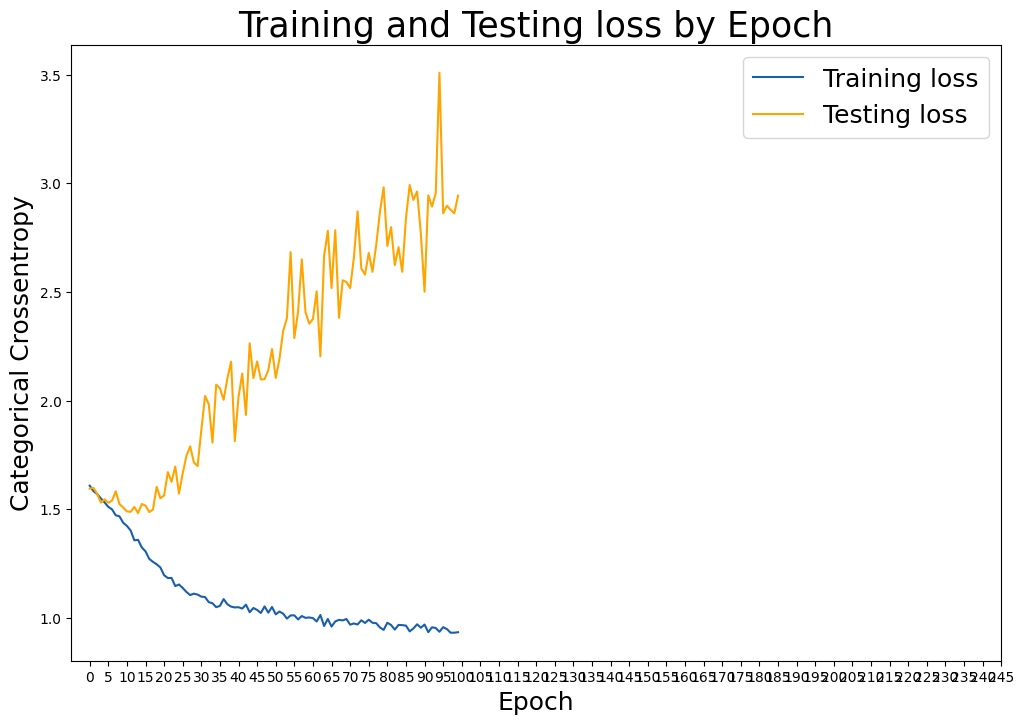

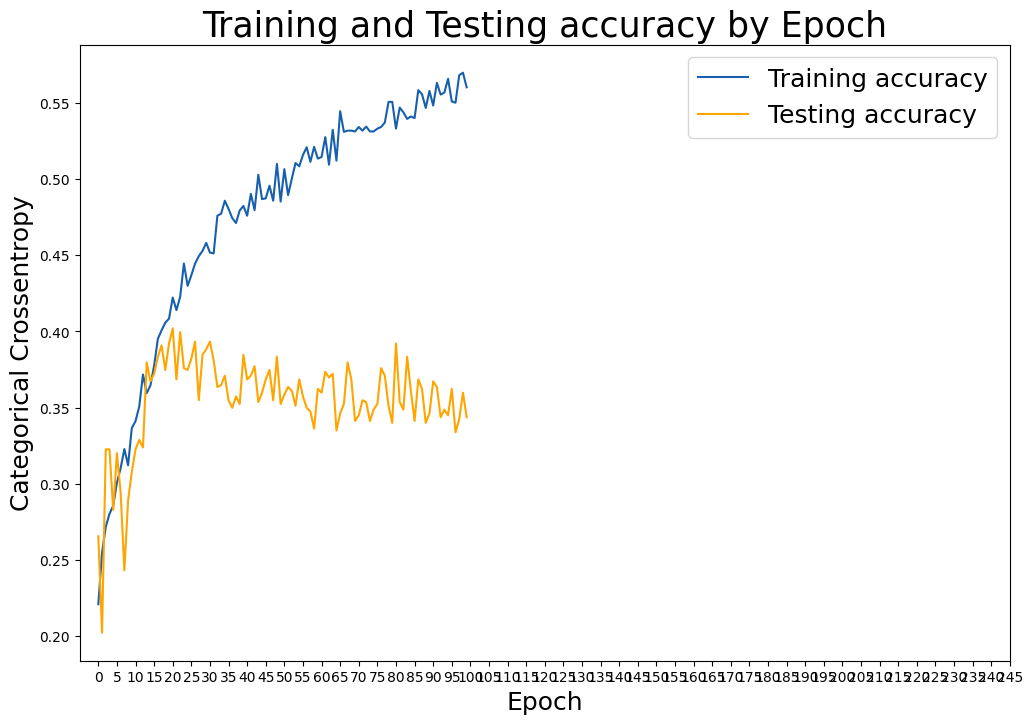

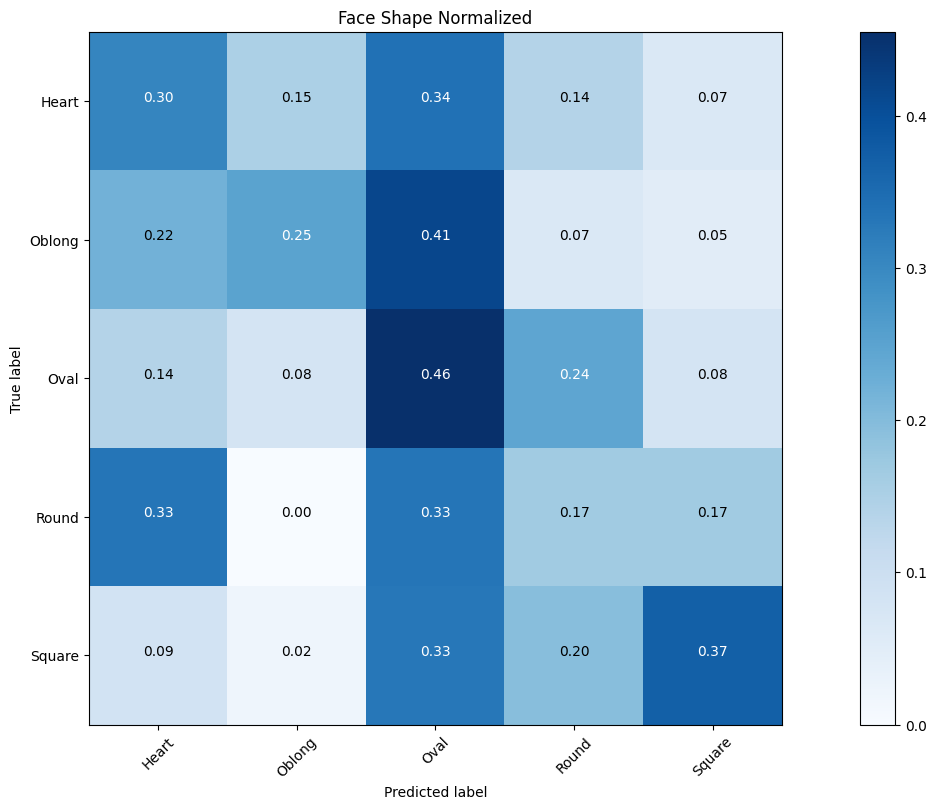

In [ ]:
plot_summary_results(model_4, history_4, 250)

Save the model


In [ ]:
model_path = '/content/drive/MyDrive/archive/rgb_oct12_3.keras'
tf.keras.models.save_model(
    model_4, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None
   )


filename = model_path.replace('.keras','') + '_rgb_oct12_3.keras'   # change the filename for new iterations
model_4.save(filename)

In [ ]:
loaded_model = tf.keras.models.load_model(filename)

# Compare the predictions from the model_4 vs. the saved version of model_4
mod4_predict = np.argmax(model_4.predict(X_test), axis=-1)
loaded4_predict = np.argmax(loaded_model.predict(X_test), axis=-1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded4_predict - mod4_predict)}')

Difference in predictions: Saved model vs. original model is 0


# VGG Face

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import pickle
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
def plot_results(mod_history, metric, epochs):

      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()

In [ ]:
 cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

      print(cm)

      plt.figure(figsize=(16,8))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

In [ ]:
path_vggface = '/content/drive/MyDrive/archive/vgg_face_weights.h5/vgg_face_weights.h5'


In [ ]:
base_model = VGG16(input_shape=(224, 224, 3),  # same as our input
                   include_top=False,  # exclude the last layer
                   weights=None)  # use VGGFace Weights
base_model.load_weights(path_vggface, by_name=True, skip_mismatch=True)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
model_t1 = Sequential()

In [ ]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(64, activation='relu')(x)  # add 1 fully connected layer, try with 512 first
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)  # add final layer

model_t1 = tf.keras.models.Model(base_model.input, x)



model_t1.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_t1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,709 (62.26 MB)

 Trainable params: 1,606,021 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Reshape X_train to have 4 dimensions (add the channels dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# Now you can call datagen.fit(X_train)
datagen.fit(X_train)

In [ ]:
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)
datagen.fit(X_train)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (3761, 224, 224)

In [ ]:
def train_test_prep(training_data_array, testing_data_array):

    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)

    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # Convert grayscale images to RGB by replicating the grayscale channel
    X_train = np.repeat(X_train[..., np.newaxis], 3, -1) # Replicate grayscale channel 3 times
    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)   # Replicate grayscale channel 3 times

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [ ]:
if X_train.shape[-1] == 1:
    X_train = np.repeat(X_train, 3, axis=-1)
    X_test = np.repeat(X_test, 3, axis=-1)

In [ ]:
history_t1 = model_t1.fit(datagen.flow(X_train, y_train, batch_size=32),
                          steps_per_epoch=int(len(X_train)/32), epochs=150,
                          validation_data=(X_test, y_test))

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

# ... (rest of your code)

# Load the VGGFace weights (ensure the path is correct)
path_vggface = '/content/drive/MyDrive/archive/vgg_face_weights.h5/vgg_face_weights.h5'

# Create the base model
base_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None  # Initialize with no weights
)

# Load the weights after the model is created to avoid variable creation during `@tf.function` call
base_model.load_weights(path_vggface, by_name=True, skip_mismatch=True)


# Freeze layers (if needed)
for layer in base_model.layers:
    layer.trainable = False

# Build the final model using the functional API:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Set training=False to prevent updating batch norm stats
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)
model_t1 = tf.keras.Model(inputs, x)

# Compile the model
model_t1.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Create and fit the data generator:
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)
datagen.fit(X_train)

# Fit the model using fit():
history_t1 = model_t1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=int(len(X_train) / 32),
    epochs=50,
    validation_data=(X_test, y_test)
)

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/'
tf.keras.models.save_model(
    model_t1, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

In [ ]:
filename = model_path + 'vgg16-face-1'   # change the filename for new iterations
model_t1.save(filename)

In [ ]:
loaded_model = tf.keras.models.load_model(filename)
mod_t1_predict = np.argmax(model_t1.predict(X_test), axis=1)
loaded_t1_predict = np.argmax(loaded_model.predict(X_test), axis=1)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded_t1_predict - mod_t1_predict)}\nModel was correctly saved.')

In [ ]:
plot_summary_results(model_t1, history_t1, 50)

In [ ]:
history_t2 = model_t1.fit(datagen.flow(X_train, y_train, batch_size=32),
                          steps_per_epoch=len(X_train)/32, epochs=20,
                          validation_data=(X_test, y_test))

In [ ]:

filename = model_path + 'vgg16-face-2'   # change the filename for new iterations
model_t1.save(filename)

In [ ]:
loaded_model = tf.keras.models.load_model(filename)
mod_t1_predict = np.argmax(model_t1.predict(X_test), axis=1)
loaded_t1_predict = np.argmax(loaded_model.predict(X_test), axis=1)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded_t1_predict - mod_t1_predict)}\nModel was correctly saved.')

In [ ]:
plot_summary_results(model_t1, history_t2, 20)

# Predict

In [ ]:
y_label_dict = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}



In [ ]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [ ]:
test_img = cv2.imread("/content/images.jpg")


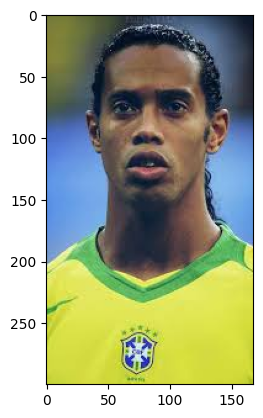

In [ ]:
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB));

In [ ]:
test_img.shape

(1, 224, 224, 3)

In [ ]:
t2 = cv2.imread("/content/1695273844_kareena-kapoor-2.jpg")

In [ ]:
def predict_face(img_array):

    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB));

    test_img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)


    test_img_gray = cv2.cvtColor(test_img_rgb, cv2.COLOR_RGB2GRAY)

    # Resize the image to 224x224
    test_img_resized = cv2.resize(test_img_gray, (224, 224))

    # Expand the dimensions to match the model's input shape (1, 224, 224, 1)
    test_img_resized = np.expand_dims(test_img_resized, axis=-1)  # Add channel dimension
    test_img_resized = np.expand_dims(test_img_resized, axis=0)  # Add batch dimension


    prediction = model_4.predict(test_img_resized)

    print(prediction)
    predicted_class = np.argmax(prediction)

    if predicted_class == 0:
      print("heart")
    elif predicted_class == 1:
      print("oblong")
    elif predicted_class == 2:
      print("oval")
    elif predicted_class == 3:
      print("round")
    elif predicted_class == 4:
      print("square")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0. 0. 1. 0. 0.]]
round


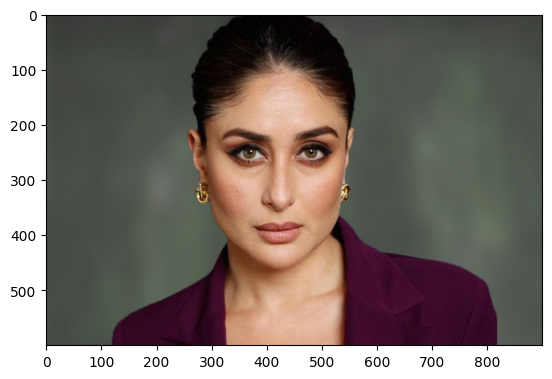

In [ ]:
predict_face(t2)

In [ ]:
t3 = cv2.imread("/content/images (2).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[1. 0. 0. 0. 0.]]
heart


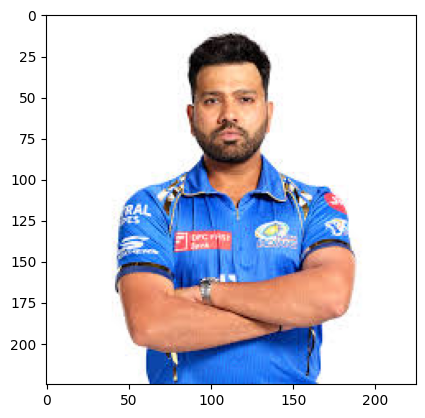

In [ ]:
predict_face(t3
             )

In [ ]:
t4=cv2.imread("/content/rs.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[1. 0. 0. 0. 0.]]
heart


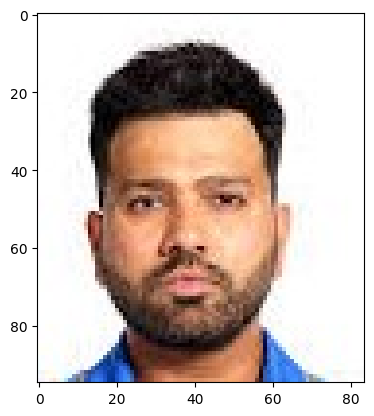

In [ ]:
predict_face(t4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[0. 0. 0. 1. 0.]]
round


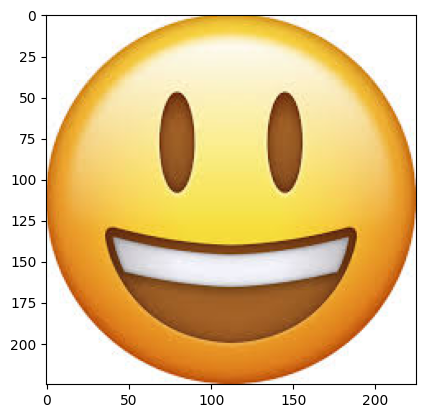

In [ ]:
t5=cv2.imread("/content/images (3).jpg")
predict_face(t5)

# Deploy


In [4]:
!pip install streamlit opencv-python-headless tensorflow ngrok mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
model1_path = '/content/drive/MyDrive/archive/rgb_oct12_3_rgb_oct12_3.keras'

model1 = tf.keras.models.load_model(model1_path)

In [8]:
model = tf.keras.models.load_model("/content/drive/MyDrive/archive/face_classification_final2.h5")

In [5]:
pip install pyngrok

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ngrok authtoken 2uzMZQgddAJnJwliNEmXnFmY9LE_3v4c8RqyUhSwqM1BzYmU5

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


 New Features to Add
✅ Face Detection (Auto-crop face using OpenCV)
✅ Multiple Face Support (Detect and classify multiple faces in one image)
✅ Confidence Score (Show the model’s confidence in the prediction)
✅ Filters & Adjustments (Brightness/contrast adjustments before prediction)
✅ Download Results (Save the classified image with glasses overlay)
✅ Custom Styling (Better UI with colors and layout improvements)

Deepseek

In [7]:
!pip install streamlit-cropper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 4.7 MB/s eta 0:00:00


In [11]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import tempfile
import os
from io import BytesIO
from streamlit_cropper import st_cropper
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(
    page_title="Face Shape Classifier & Glasses Recommendation",
    page_icon="👓",
    layout="wide",
    initial_sidebar_state="expanded"
)

@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model("/content/drive/MyDrive/archive/face_classification_final2.h5")
        st.sidebar.success("Model loaded successfully!")
        return model
    except Exception as e:
        st.sidebar.error(f"Error loading model: {str(e)}")
        return None

model = load_model()

FACE_SHAPES = {
    "Oval": "🧺",
    "Round": "⚪",
    "Square": "🟧",
    "Heart": "❤️",
    "Diamond": "💎"
}

recommendations = {
    "Oval": {
        "description": "Oval faces are balanced and versatile. Almost any frame style works well!",
        "best_frames": ["Round", "Aviator", "Wayfarer", "Rectangle"],
        "avoid": "Oversized frames that can overwhelm your balanced proportions",
        "celebrity_examples": ["Beyoncé", "George Clooney", "Ryan Reynolds"]
    },
    "Round": {
        "description": "Round faces benefit from frames that add angles and definition.",
        "best_frames": ["Square", "Rectangle", "Browline", "Cat-eye"],
        "avoid": "Small, round frames that emphasize roundness",
        "celebrity_examples": ["Emma Stone", "Leonardo DiCaprio", "Selena Gomez"]
    },
    "Square": {
        "description": "Square faces have strong jawlines and need frames to soften angles.",
        "best_frames": ["Round", "Oval", "Aviator", "Rimless"],
        "avoid": "Angular, boxy frames that emphasize squareness",
        "celebrity_examples": ["Angelina Jolie", "Brad Pitt", "Keira Knightley"]
    },
    "Heart": {
        "description": "Heart-shaped faces need frames that balance the wider forehead.",
        "best_frames": ["Light-colored", "Rimless", "Bottom-heavy", "Round"],
        "avoid": "Top-heavy or decorative frames that draw attention upward",
        "celebrity_examples": ["Reese Witherspoon", "Ryan Gosling", "Scarlett Johansson"]
    },
    "Diamond": {
        "description": "Diamond/Triangle faces need frames that highlight cheekbones and soften angles.",
        "best_frames": ["Oval", "Cat-eye", "Rimless", "Semi-rimless"],
        "avoid": "Narrow or boxy frames that don't complement cheekbones",
        "celebrity_examples": ["Rihanna", "Johnny Depp", "Zac Efron"]
    }
}

GLASSES_IMAGES = {
    "Oval": "/content/drive/MyDrive/archive/oval glasses final.jpg",
    "Round": "/content/drive/MyDrive/archive/round glasses final.jpg",
    "Square": "/content/drive/MyDrive/archive/square glasses final.jpg",
    "Heart": "/content/drive/MyDrive/archive/heart glasses final.jpg",
    "Diamond": "/content/drive/MyDrive/archive/diamond glasses final.jpg"
}

def preprocess_image(image, target_size=(224, 224)):
    try:
        if image.mode != 'RGB':
            image = image.convert('RGB')
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(1.2)
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.1)

        image = image.resize(target_size)
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=(0, -1))
        return image, image_array
    except Exception as e:
        st.error(f"Error processing image: {str(e)}")
        return None, None

def display_results(prediction, original_image, processed_image):
    predicted_index = np.argmax(prediction)
    predicted_class = list(FACE_SHAPES.keys())[predicted_index]
    confidence_score = np.max(prediction) * 100

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("Prediction Results")
        st.markdown(f"### Predicted Face Shape: {predicted_class} {FACE_SHAPES[predicted_class]}")
        st.progress(int(confidence_score))
        st.caption(f"Confidence: {confidence_score:.1f}%")

        st.subheader("Probability Distribution")
        fig, ax = plt.subplots()
        sns.barplot(x=list(FACE_SHAPES.keys()), y=prediction[0]*100, ax=ax, palette="viridis")
        ax.set_ylabel("Probability (%)")
        ax.set_xlabel("Face Shape")
        plt.xticks(rotation=45)
        st.pyplot(fig)

    with col2:
        st.subheader("Recommendations")
        rec = recommendations[predicted_class]
        st.markdown(f"**Description:** {rec['description']}")
        st.markdown(f"**Best frame styles:** {', '.join(rec['best_frames'])}")
        st.markdown(f"**Frames to avoid:** {rec['avoid']}")
        st.markdown(f"**Celebrities with this face shape:** {', '.join(rec['celebrity_examples'])}")

        try:
            glasses_img = Image.open(GLASSES_IMAGES[predicted_class])
            st.image(glasses_img, caption=f"Recommended Glasses for {predicted_class} Face", use_column_width=True)
        except Exception as e:
            st.warning("Couldn't load glasses image example")
            st.text(f"Error: {str(e)}")

    st.subheader("Image Processing")
    before_col, after_col = st.columns(2)
    with before_col:
        st.image(original_image, caption="Original Image", use_column_width=True)
    with after_col:
        st.image(processed_image, caption="Processed Image", use_column_width=True)

def main():
    st.title("👓 Face Shape Classifier & Glasses Recommendation")
    st.markdown("""
    Upload a photo of your face to discover your face shape and get personalized glasses recommendations
    that will complement your features perfectly!
    """)

    with st.sidebar:
        st.header("Settings")
        enhance_options = st.checkbox("Enable Image Enhancement", True)
        auto_crop = st.checkbox("Auto-crop Face (Experimental)", False)
        show_advanced = st.checkbox("Show Advanced Options", False)

        if show_advanced:
            brightness = st.slider("Brightness Adjustment", 0.5, 2.0, 1.0, 0.1)
            contrast = st.slider("Contrast Adjustment", 0.5, 2.0, 1.0, 0.1)
            sharpness = st.slider("Sharpness Adjustment", 0.5, 2.0, 1.0, 0.1)

    upload_option = st.radio("Upload Option:", ("Upload Image", "Take Photo"))

    if upload_option == "Upload Image":
        uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])
    else:
        uploaded_file = st.camera_input("Take a photo")

    if uploaded_file is not None and model is not None:
        try:
            original_image = Image.open(uploaded_file)

            if auto_crop:
                st.info("Please crop your image to focus on the face")
                cropped_image = st_cropper(original_image, realtime_update=True, box_color='#FF0000')
                original_image = cropped_image

            processed_image, image_array = preprocess_image(original_image)

            if processed_image and image_array is not None:
                if enhance_options and show_advanced:
                    enhancer = ImageEnhance.Brightness(processed_image)
                    processed_image = enhancer.enhance(brightness)

                    enhancer = ImageEnhance.Contrast(processed_image)
                    processed_image = enhancer.enhance(contrast)

                    enhancer = ImageEnhance.Sharpness(processed_image)
                    processed_image = enhancer.enhance(sharpness)

                with st.spinner("Analyzing face shape..."):
                    prediction = model.predict(image_array)

                display_results(prediction, original_image, processed_image)

        except Exception as e:
            st.error(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Overwriting app.py


In [12]:
import os
import subprocess
from pyngrok import ngrok

# List existing tunnels and kill them
active_tunnels = ngrok.get_tunnels()
for tunnel in active_tunnels:
    print(f"Killing tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)

# Start Streamlit in the background
subprocess.Popen(["streamlit", "run", "app.py"])

# Open a tunnel on port 8501
public_url = ngrok.connect(8501, "http")
print("Streamlit app is running at:", public_url)

Killing tunnel: https://722a-35-192-87-98.ngrok-free.app
Streamlit app is running at: NgrokTunnel: "https://f157-35-192-87-98.ngrok-free.app" -> "http://localhost:8501"
